# How to Replace Raster Cell Values with Values from A Different Raster Datset

Sometimes you have many bad pixels in a LS scene that you wish to replace or fill in with pixels from another scene. In this lesson you will learn how to replace pixels in one scene with those from another using Numpy.

To begin, open both of the pre-fire raster stacks, the cloud free and the cloud with cold spring fire data.

In [12]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
from shapely.geometry import mapping, box
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and get work dir
data = et.data.get_data("cold-springs-fire")
data_2 = et.data.get_data("cs-test-landsat")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

First, make a masked raster stack of cold springs cloud data.

In [13]:
# Stack the LS pre fire data
landsat_paths_pre_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                      "LC080340322016070701T1-SC20180214145604", "crop", 
                                      "*band*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

landsat_pre_cloud, landsat_pre_meta = es.stack(
    landsat_paths_pre, nodata=-9999)

# Calculate bounds object
landsat_pre_cloud_ext_bds = rio.transform.array_bounds(
    landsat_pre_cloud.shape[1],
    landsat_pre_cloud.shape[2],
    landsat_pre_meta["transform"])

# Open the pixel_qa layer for your LS scene
landsat_pre_cl_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                   "LC080340322016070701T1-SC20180214145604", "crop", 
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

with rio.open(landsat_pre_cl_path) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    
# Generate array of all possible cloud/shadow values
cloud_shadow = [328, 392, 840, 984, 1350]
cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
high_confidence_cloud = [480, 992]

vals_to_mask = cloud_shadow + cloud + high_confidence_cloud

# Call the earthpy mask function using pixel QA layer
landsat_pre_cloud_masked = em.mask_pixels(landsat_pre_cloud, landsat_qa,
                                         vals=vals_to_mask)

Plot the data to ensure that the cloud covered pixels are masked

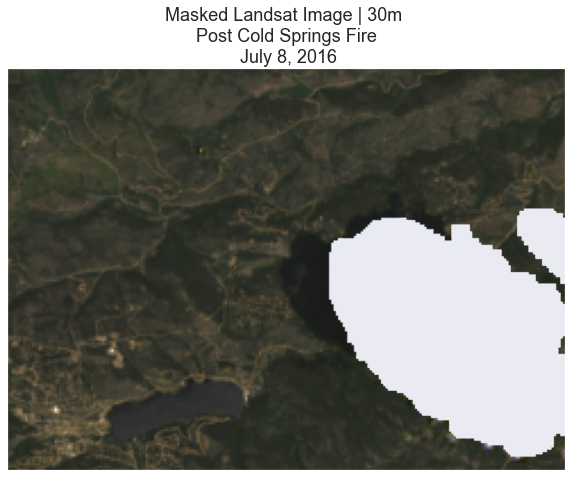

In [14]:
ep.plot_rgb(landsat_pre_cloud_masked,
           rgb=[3, 2, 1],
           title="Masked Landsat Image | 30m \n Post Cold Springs Fire \n July 8, 2016")

plt.show()

### Read and stack cloud free data

Next, read in and stack the cloud free LS data. Below you create a bound object that contains the spatial extent of the cloud free raster. You will use this to ensure that the bounds of both datasets are the same before replacing pixel values.

In [15]:
# Read in the "cloud free" landsat data that you downloaded
landsat_paths_pre_cloud_free = glob(os.path.join("data", "cs-test-landsat", "*band*.tif"))

landsat_paths_pre_cloud_free.sort()

# Stack the data
landsat_pre_cloud_free, landsat_pre_cloud_free_meta = es.stack(
    landsat_paths_pre_cloud_free,
    nodata=-9999)

# Calculate bounds - this is just for comparison later, not required
landsat_no_clouds_bds = rio.transform.array_bounds(
    landsat_pre_cloud_free.shape[1],
    landsat_pre_cloud_free.shape[2],
    landsat_pre_cloud_free_meta["transform"])

In [16]:
# Are the bounds the same?
landsat_no_clouds_bds == landsat_pre_cloud_ext_bds

False

In [17]:
# Reorder the min and max values
cloud_free_scene_bds = box(*landsat_no_clouds_bds)
cloudy_scene_bds = box(*landsat_pre_cloud_ext_bds)

# Do the data overlap spatially?
cloud_free_scene_bds.intersects(cloudy_scene_bds)

True

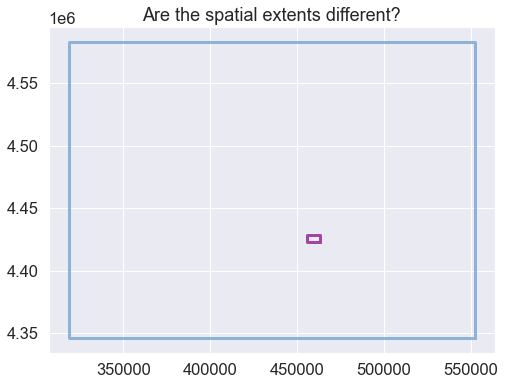

In [18]:
# Plot the boundaries
x, y = cloud_free_scene_bds.exterior.xy
x1, y1 = cloudy_scene_bds.exterior.xy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x, y, color="#6699cc", alpha=0.7,
       linewidth=3, solid_capstyle="round", zorder=2)

ax.plot(x1, y1, color="purple", alpha=0.7,
       linewidth=3, solid_capstyle="round", zorder=2)

ax.set_title("Are the spatial extents different?")

plt.show()

In [19]:
# Is the CRS the same in each raster?
landsat_pre_meta["crs"] == landsat_pre_cloud_free_meta["crs"]

True

In [20]:
# Are the shapes the same?
landsat_pre_cloud.shape == landsat_pre_cloud_free.shape

False

You've now determined that
1. the data do not have the same bounsd
2. the data are in the same CRS
3. the data do overlap (or intersect).

Since the 2 images do not cover the same spatial extent, the next step is to CROP the cloud-free data (with a larger spatial extent) to the spatial extent of the cloudy data so we can reassign all cloud covered pixels to the values in the cloud free data (in the same location).

In [21]:
landsat_clouds_clip = es.extent_to_json(list(landsat_pre_cloud_ext_bds))

In [23]:
# Export the cloud free data as a tiff and reimport / crop the data
landsat_cloud_free_out_path = os.path.join("data", "outputs", "cloud_mask")

if not os.path.exists(landsat_cloud_free_out_path):
    os.makedirs(landsat_cloud_free_out_path)
    
cropped_cloud_list = es.crop_all(landsat_paths_pre_cloud_free,
                                landsat_cloud_free_out_path,
                                [landsat_clouds_clip], overwrite=True)

landsat_pre_cloud_free, landsat_pre_cloud_free_meta = es.stack(cropped_cloud_list)

In [24]:
# View the shape of each scene, are they the same?
landsat_pre_cloud_free.shape, landsat_pre_cloud_masked.shape

((7, 177, 246), (7, 177, 246))

Once the data are cropped to the same extent, you can replace values using numpy.

In [26]:
# Get the mask layer form the pre_cloud data
mask = landsat_pre_cloud_masked.mask

# Copy the pre_cloud_data ot a new array
# So you don't impact the original array (optional but suggested!)
landsat_pre_cloud_masked_copy = np.copy(landsat_pre_cloud_masked)

# Assign every cell in the new array that is masked
# to the value in the same cell location as the cloud free data
# landsat_pre_cloud_c[mask] = landsat_pre_noclouds_crop[mask]
landsat_pre_cloud_masked_copy[mask] = landsat_pre_cloud_free[mask]

Finally, plot the data. Does it look like it reassigned values correctly?

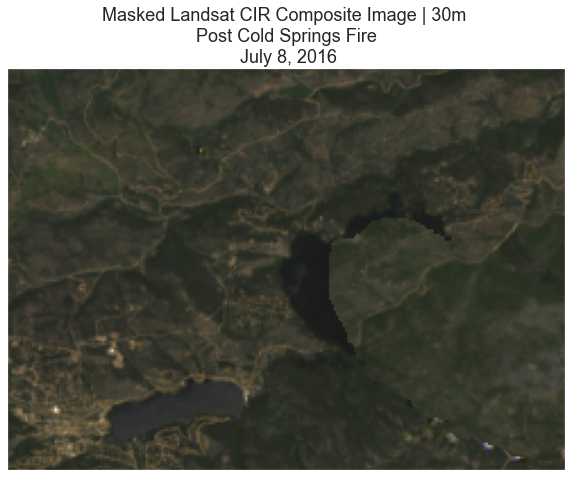

In [27]:
ep.plot_rgb(landsat_pre_cloud_masked_copy,
           rgb=[3, 2, 1],
           title="Masked Landsat CIR Composite Image | 30m \n Post Cold Springs Fire \n July 8, 2016")

plt.show()